In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Copy dataset from Google Drive
!cp -r /content/drive/MyDrive/COMP9517_ZXCZH /content/

# Dataset paths
TRAIN_DIR = '/content/COMP9517_ZXCZH/train'
TEST_DIR = '/content/COMP9517_ZXCZH/test'

N_CLUSTERS = 100  # Number of visual words
SIFT_SIZE = 128

# Image preprocessing
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = ImageFolder(TEST_DIR, transform=transform)

# Create SIFT detector
sift = cv2.SIFT_create()

def extract_sift_features(dataset):
    """Extract SIFT features from dataset"""
    descriptors = []
    labels = []

    for img, label in DataLoader(dataset, batch_size=1, shuffle=False):
        img = img.squeeze().numpy() * 255
        img = img.astype(np.uint8)

        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            descriptors.append(des)
            labels.append(label.item())

    return np.vstack(descriptors), np.array(labels)

# Train visual vocabulary using K-Means
print("Extracting training features for clustering...")
all_descriptors, _ = extract_sift_features(train_dataset)

print(f"Training K-Means with {N_CLUSTERS} clusters...")
kmeans = MiniBatchKMeans(
    n_clusters=N_CLUSTERS,
    batch_size=1024,
    reassignment_ratio=0.1,
    random_state=42
)
kmeans.fit(all_descriptors)

def image_to_bow(img, kmeans):
    """Convert image to BoW histogram using trained K-Means"""
    img = img.squeeze().numpy() * 255
    img = img.astype(np.uint8)

    _, des = sift.detectAndCompute(img, None)
    if des is None:
        return np.zeros(N_CLUSTERS)  # Ensure consistent output dimension

    visual_words = kmeans.predict(des)
    hist, _ = np.histogram(visual_words, bins=N_CLUSTERS, range=(0, N_CLUSTERS))
    return hist / (hist.sum() + 1e-6)  # Normalize with smoothing term

def extract_bow_features(dataset):
    """Extract BoW features for the entire dataset"""
    features = []
    labels = []

    for img, label in DataLoader(dataset, batch_size=1, shuffle=False):
        bow_feature = image_to_bow(img, kmeans)
        features.append(bow_feature)
        labels.append(label.item())

    # Check feature dimensions
    assert all(feature.shape == (N_CLUSTERS,) for feature in features), \
        "Inconsistent feature dimensions! Check image_to_bow function."

    return np.array(features), np.array(labels)

# Feature extraction
print("Extracting training BOW features...")
X_train, y_train = extract_bow_features(train_dataset)
print("Extracting test BOW features...")
X_test, y_test = extract_bow_features(test_dataset)

# SVM pipeline
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(
        C=3,
        kernel='rbf',
        random_state=42
    )
)

# Train and evaluate SVM
print("Training SVM...")
svm_pipeline.fit(X_train, y_train)

train_pred = svm_pipeline.predict(X_train)
test_pred = svm_pipeline.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")


Extracting training features for clustering...
Training K-Means with 100 clusters...
Extracting training BOW features...
Extracting test BOW features...
Training SVM...
Train Accuracy: 0.8991
Test Accuracy: 0.6685


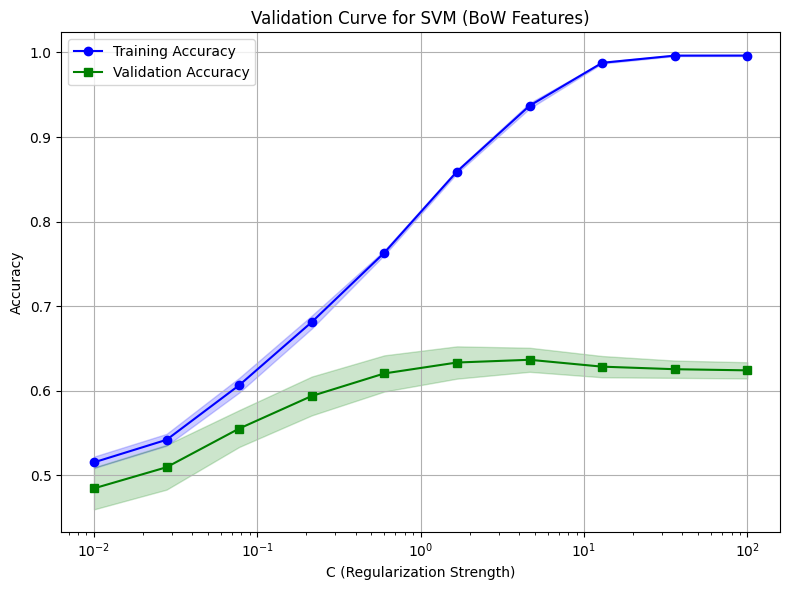

In [ ]:
!pip install scikit-learn matplotlib
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Define the range of C values to be tested
param_range = np.logspace(-2, 2, 10)  # 10 values from 0.01 to 100

# Perform cross-validation to record training and validation accuracy
train_scores, test_scores = validation_curve(
    svm_pipeline,
    X_train, y_train,
    param_name='svc__C',  # Note: param_name must use the name from the pipeline
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Compute mean and standard deviation for each C value
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 6))
plt.semilogx(param_range, train_mean, label="Training Accuracy", color="blue", marker='o')
plt.semilogx(param_range, test_mean, label="Validation Accuracy", color="green", marker='s')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title("Validation Curve for SVM (BoW Features)")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()




SIFT + SVM Final Evaluation on Test Set:
SIFT+SVM Test dataset Accuracy: 66.85%
SIFT+SVM Test dataset Precision: 67.01%
SIFT+SVM Test dataset Recall: 66.92%
SIFT+SVM Test dataset F1-score: 66.79%

SIFT+SVM Final classification report:
              precision    recall  f1-score   support

 Agriculture       0.76      0.66      0.71       160
     Airport       0.53      0.48      0.51       170
       Beach       0.59      0.56      0.57       160
        City       0.70      0.81      0.75       160
      Desert       0.57      0.54      0.56       160
      Forest       0.83      0.85      0.84       160
   Grassland       0.55      0.68      0.61       160
     Highway       0.59      0.66      0.62       160
        Lake       0.49      0.44      0.47       160
    Mountain       0.78      0.82      0.80       160
     Parking       0.96      0.86      0.91       160
        Port       0.77      0.68      0.72       160
     Railway       0.68      0.69      0.69       160
 Reside

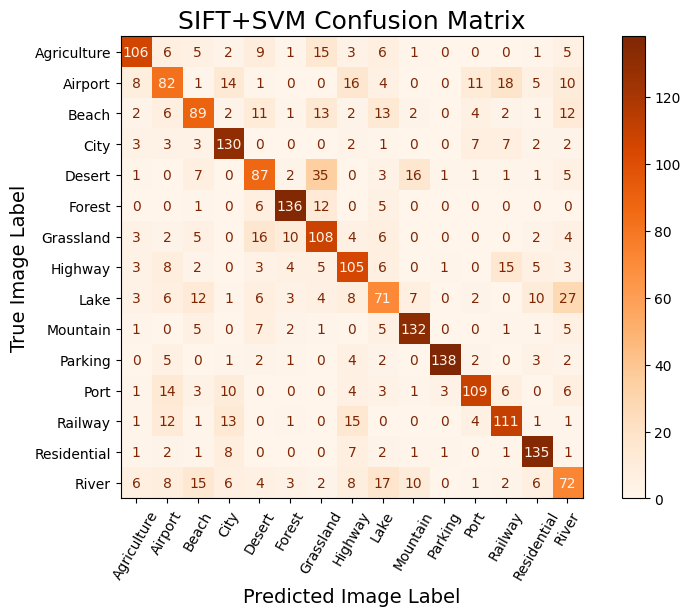

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# _______________________SIFT_SVM Final Evaluation______________________________
print("\nSIFT + SVM Final Evaluation on Test Set:")

# Use accuracy, precision, recall and f1 as the evaluation metrics.
accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred, average='macro')
recall = recall_score(y_test, test_pred, average='macro')
f1 = f1_score(y_test, test_pred, average='macro')

print(f"SIFT+SVM Test dataset Accuracy: {accuracy * 100:.2f}%")
print(f"SIFT+SVM Test dataset Precision: {precision * 100:.2f}%")
print(f"SIFT+SVM Test dataset Recall: {recall * 100:.2f}%")
print(f"SIFT+SVM Test dataset F1-score: {f1 * 100:.2f}%")

# SIFT_SVM Classification report
print("\nSIFT+SVM Final classification report:")
print(classification_report(y_test, test_pred, target_names=test_dataset.classes))

# SIFT_SVM Confusion matrix:
cm = confusion_matrix(y_test, test_pred)
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Oranges', xticks_rotation=60, ax=ax)
plt.title("SIFT+SVM Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Image Label", fontsize=14)
plt.ylabel("True Image Label", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()